In [33]:
!pip install tf-models-official bert-tensorflow bert-for-tf2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 14.5 MB/s 
     |████████████████████████████████| 64 kB 3.3 MB/s 
     |████████████████████████████████| 41 kB 176 kB/s 
     |████████████████████████████████| 352 kB 89.6 MB/s 
     |████████████████████████████████| 1.1 MB 80.3 MB/s 
     |████████████████████████████████| 662 kB 76.2 MB/s 
     |████████████████████████████████| 2.3 MB 66.5 MB/s 
     |████████████████████████████████| 5.8 MB 82.0 MB/s 
     |████████████████████████████████| 38.2 MB 1.3 MB/s 
     |████████████████████████████████| 238 kB 82.5 MB/s 
     |████████████████████████████████| 588.3 MB 18 kB/s 
     |████████████████████████████████| 118 kB 95.7 MB/s 
     |████████████████████████████████| 1.3 MB 62.9 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 439 kB 82.4 MB/s 
     |███████████████████████████████

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/NLP/HNP

/content/drive/MyDrive/NLP/HNP


In [3]:
ls

'Copy of arguments-training.tsv'  'Copy of level1-labels-training.tsv'
'Copy of labels-training.tsv'      Untitled0.ipynb


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import keras
import tensorflow as tf
from keras.layers import *
from keras.models import *
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from official.nlp.configs import bert
from bert import bert_tokenization

import os

In [7]:
arguments = pd.read_csv("Copy of arguments-training.tsv", delimiter='\t')
labels = pd.read_csv("Copy of labels-training.tsv", delimiter='\t')

In [8]:
arguments.head()

,Argument ID,Conclusion,Stance,Premise
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...
1,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
2,A01003,We should abandon marriage,against,marriage is the ultimate commitment to someone...
3,A01004,We should ban naturopathy,against,it provides a useful income for some people
4,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...


In [9]:
labels.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01003,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01004,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X = arguments[['Conclusion', 'Stance', 'Premise']]
Y = labels.drop('Argument ID', axis=1)

In [11]:
X.head(2)

,Conclusion,Stance,Premise
0,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...
1,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...


In [12]:
Y.head(2)

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [62]:
X_train['Stance'] = X_train['Stance'].map({'in favor of': 1, 'against': 0})
X_test['Stance'] = X_test['Stance'].map({'in favor of': 1, 'against': 0})

In [63]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tokenizer = bert_tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

In [64]:
def sentence_encoder(s, tokenizer):
  
  
    tokens = list(tokenizer.tokenize(str(s)))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [65]:
X_train.head()

,Conclusion,Stance,Premise
1034,We should ban the use of child actors,1,children should be at school and not working. ...
653,We should adopt gender-neutral language,0,we should not place any restrictions on freedo...
1144,We should legalize organ trade,0,people would sell organs because to them money...
2650,We should subsidize embryonic stem cell research,1,embryonic stem cell research is extremely valu...
2755,We should fight for the abolition of nuclear w...,0,mutually assured destruction is a crucial meth...


In [66]:
def bert_input_encoder(train_corpus, tokenizer):
    sentence1 = tf.ragged.constant([sentence_encoder(s, tokenizer) for s in np.array(train_corpus['Premise'])])
    sentence2 = tf.ragged.constant([sentence_encoder(s, tokenizer) for s in np.array(train_corpus['Conclusion'])])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
    
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    segment_cls = tf.zeros_like(cls)
    segment_s1 = tf.zeros_like(sentence1)
    segment_s2 = tf.ones_like(sentence2)
    input_segment_ids = tf.concat([segment_cls, segment_s1, segment_s2], axis=-1).to_tensor()
    #train_corpus['Stance'] = train_corpus['Stance'].map({'in favor of': 1, 'against': 0})
    input_values = tf.convert_to_tensor(np.array(train_corpus.drop(['Premise', 'Conclusion'], axis=1)))

    inputs_dic = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_segment_ids': input_segment_ids,
        'input_values': input_values
    }

    return inputs_dic

In [67]:
def inference_model_builder():
    max_seq_length = 169

    input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    input_segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32, name="input_segment_ids")
    input_values = Input(shape=(1, ), dtype=tf.int32, name="input_values")
    url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
    bert_layer = hub.KerasLayer(url, trainable=True)

    pooled_output, _ = bert_layer([input_word_ids, input_mask, input_segment_ids])
    bert_output = Dense(units=128, activation='relu')(pooled_output)
    
    dense_1 = Dense(512, activation='relu')(input_values)
    dropout_1 = Dropout(0.3)(dense_1)
    dense_2 = Dense(128, activation='relu')(dropout_1)

    merged = concatenate([bert_output, dense_2], axis=1)
    dropout_2 = Dropout(0.2)(merged)
    dense_3 = Dense(64, activation='relu')(dropout_2)

    outputs = []
    for i in range(20):
        dropout = Dropout(0.15)(dense_3)
        output = Dense(1, activation='sigmoid', kernel_regularizer='l2', kernel_initializer='he_uniform')(dropout)
        outputs.append(output)

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_segment_ids, input_values], outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(lr=1e-4)
    model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [68]:
model = inference_model_builder()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_values (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 169)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 169)]        0           []                               
                                                                                                  
 input_segment_ids (InputLayer)  [(None, 169)]       0           []                               
                                                                                            

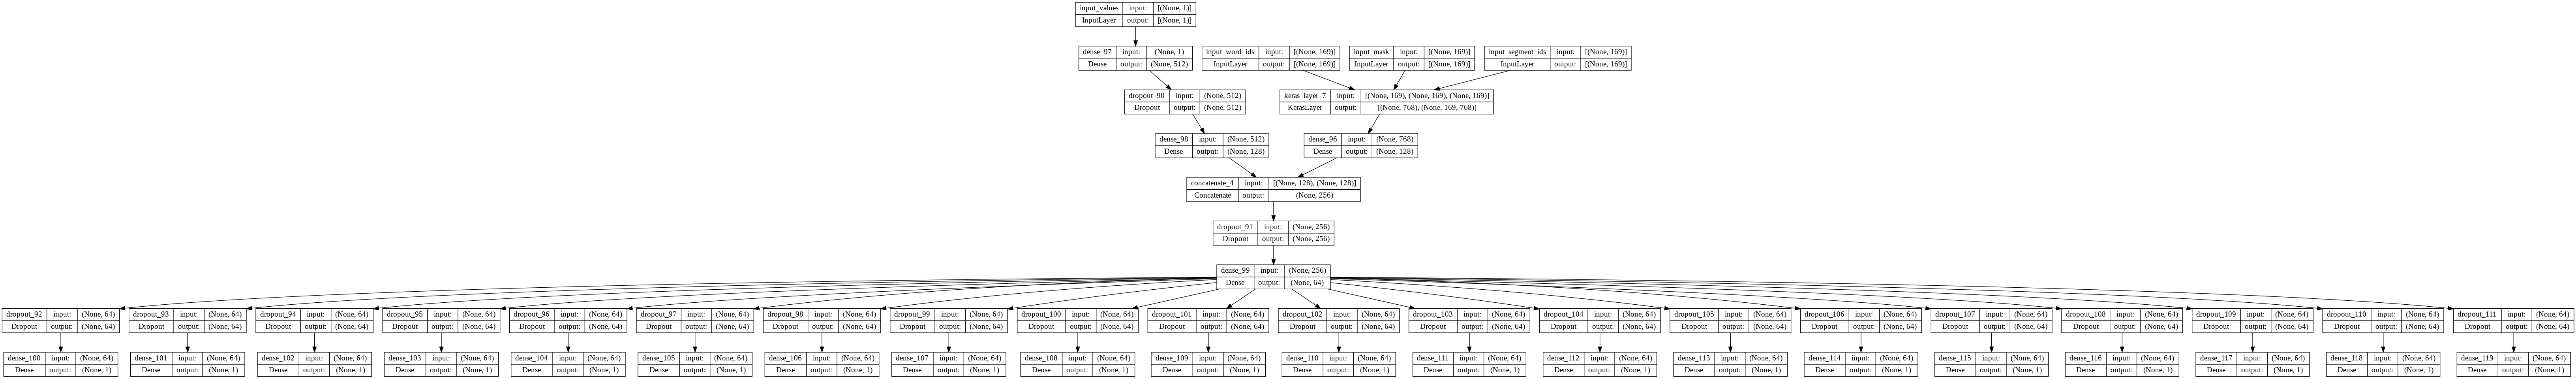

In [69]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [70]:
model_input = bert_input_encoder(X_train, tokenizer)
test_input = bert_input_encoder(X_test, tokenizer)

In [71]:
model_input

{'input_word_ids': <tf.Tensor: shape=(4698, 169), dtype=int32, numpy=
 array([[ 101, 2336, 2323, ...,    0,    0,    0],
        [ 101, 2057, 2323, ...,    0,    0,    0],
        [ 101, 2111, 2052, ...,    0,    0,    0],
        ...,
        [ 101, 2057, 2323, ...,    0,    0,    0],
        [ 101, 4507, 3065, ...,    0,    0,    0],
        [ 101, 9896, 2594, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(4698, 169), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_segment_ids': <tf.Tensor: shape=(4698, 169), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 '

In [75]:
y_train_values = y_train.values

In [78]:
model_output = []
for i in range(20):
    model_output.append(y_train_values[:, i])
len(model_output)

20

In [79]:
model.fit(model_input, model_output, epochs=20, batch_size=32, validation_split=0.15)

Epoch 1/20
125/125 [==============================] - 194s 1s/step - loss: 9.8213 - dense_100_loss: 0.5130 - dense_101_loss: 0.6142 - dense_102_loss: 0.2519 - dense_103_loss: 0.2143 - dense_104_loss: 0.6509 - dense_105_loss: 0.3652 - dense_106_loss: 0.4122 - dense_107_loss: 0.3047 - dense_108_loss: 0.7144 - dense_109_loss: 0.6738 - dense_110_loss: 0.4059 - dense_111_loss: 0.5799 - dense_112_loss: 0.2812 - dense_113_loss: 0.3376 - dense_114_loss: 0.6479 - dense_115_loss: 0.4622 - dense_116_loss: 0.7122 - dense_117_loss: 0.3459 - dense_118_loss: 0.4426 - dense_119_loss: 0.5287 - dense_100_accuracy: 0.8202 - dense_101_accuracy: 0.7333 - dense_102_accuracy: 0.9341 - dense_103_accuracy: 0.9499 - dense_104_accuracy: 0.6572 - dense_105_accuracy: 0.8775 - dense_106_accuracy: 0.8663 - dense_107_accuracy: 0.9149 - dense_108_accuracy: 0.5783 - dense_109_accuracy: 0.6464 - dense_110_accuracy: 0.8688 - dense_111_accuracy: 0.7483 - dense_112_accuracy: 0.9196 - dense_113_accuracy: 0.9031 - dense_114_

In [80]:
model.save("Model_Classifier.h5")

In [81]:
df = pd.DataFrame(model.history.history)
df.head()

,loss,dense_100_loss,dense_101_loss,dense_102_loss,dense_103_loss,dense_104_loss,dense_105_loss,dense_106_loss,dense_107_loss,dense_108_loss,...,val_dense_110_accuracy,val_dense_111_accuracy,val_dense_112_accuracy,val_dense_113_accuracy,val_dense_114_accuracy,val_dense_115_accuracy,val_dense_116_accuracy,val_dense_117_accuracy,val_dense_118_accuracy,val_dense_119_accuracy
0,9.821266,0.513045,0.614187,0.251945,0.214292,0.650898,0.365238,0.412217,0.304656,0.714367,...,0.897872,0.753191,0.960284,0.930496,0.695035,0.875177,0.612766,0.943262,0.875177,0.809929
1,9.011425,0.482401,0.584822,0.246258,0.185566,0.605259,0.312395,0.360304,0.278601,0.681464,...,0.897872,0.753191,0.960284,0.930496,0.695035,0.875177,0.612766,0.943262,0.875177,0.809929
2,8.838973,0.472848,0.576301,0.241000,0.180559,0.596101,0.307808,0.355033,0.272382,0.672492,...,0.897872,0.753191,0.960284,0.930496,0.695035,0.875177,0.612766,0.943262,0.875177,0.809929
3,8.736248,0.472675,0.573445,0.237801,0.176755,0.590990,0.308612,0.354723,0.266865,0.667693,...,0.897872,0.753191,0.960284,0.930496,0.695035,0.875177,0.612766,0.943262,0.875177,0.809929
4,8.668550,0.473327,0.569577,0.235669,0.176776,0.589729,0.300887,0.353465,0.266605,0.666308,...,0.897872,0.753191,0.960284,0.930496,0.695035,0.875177,0.612766,0.943262,0.875177,0.809929


In [84]:
df.to_csv("Model_Classifier_history.csv", index=False)

In [85]:
model_test_output = []
y_test_values = y_test.values
for i in range(20):
    model_test_output.append(y_test_values[:, i])
len(model_test_output)

20

In [86]:
df.head()

,loss,dense_100_loss,dense_101_loss,dense_102_loss,dense_103_loss,dense_104_loss,dense_105_loss,dense_106_loss,dense_107_loss,dense_108_loss,...,val_dense_110_accuracy,val_dense_111_accuracy,val_dense_112_accuracy,val_dense_113_accuracy,val_dense_114_accuracy,val_dense_115_accuracy,val_dense_116_accuracy,val_dense_117_accuracy,val_dense_118_accuracy,val_dense_119_accuracy
0,9.821266,0.513045,0.614187,0.251945,0.214292,0.650898,0.365238,0.412217,0.304656,0.714367,...,0.897872,0.753191,0.960284,0.930496,0.695035,0.875177,0.612766,0.943262,0.875177,0.809929
1,9.011425,0.482401,0.584822,0.246258,0.185566,0.605259,0.312395,0.360304,0.278601,0.681464,...,0.897872,0.753191,0.960284,0.930496,0.695035,0.875177,0.612766,0.943262,0.875177,0.809929
2,8.838973,0.472848,0.576301,0.241000,0.180559,0.596101,0.307808,0.355033,0.272382,0.672492,...,0.897872,0.753191,0.960284,0.930496,0.695035,0.875177,0.612766,0.943262,0.875177,0.809929
3,8.736248,0.472675,0.573445,0.237801,0.176755,0.590990,0.308612,0.354723,0.266865,0.667693,...,0.897872,0.753191,0.960284,0.930496,0.695035,0.875177,0.612766,0.943262,0.875177,0.809929
4,8.668550,0.473327,0.569577,0.235669,0.176776,0.589729,0.300887,0.353465,0.266605,0.666308,...,0.897872,0.753191,0.960284,0.930496,0.695035,0.875177,0.612766,0.943262,0.875177,0.809929


In [87]:
plt.style.use('fivethirtyeight')

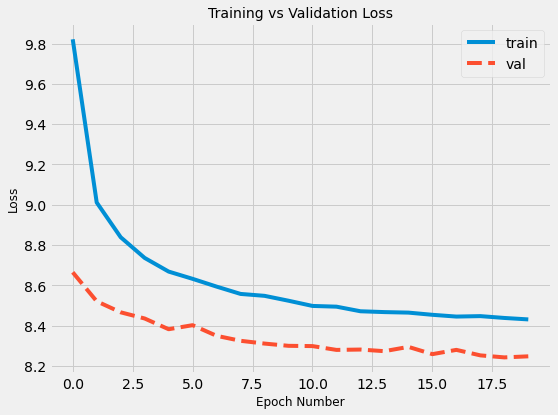

In [100]:
plt.figure(figsize=(8, 6))
plt.plot(list(range(20)), df['loss'], linestyle='-', label='train')
plt.plot(list(range(20)), df['val_loss'], linestyle='--', label='val')
plt.xlabel("Epoch Number", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training vs Validation Loss", fontsize=14)
plt.legend()
plt.savefig("Loss.png")
plt.show()

In [91]:
preds = model.predict(model_input)
len(preds)

147/147 [==============================] - 54s 362ms/step


20

In [92]:
len(preds[0])

4698

In [93]:
len(model_output[0])

4698

In [99]:
from sklearn.metrics import f1_score
train_f1 = 0
for i in range(20):
    train_f1 += f1_score(np.where(preds[i] >=0.5, 1, 0), model_output[i], average='macro')
train_f1 /= 20
print("Average Macro F1 for Training: ", train_f1)

Average Macro F1 for Training:  0.4453343277341453


In [101]:
test_preds = model.predict(test_input)
len(test_preds)

17/17 [==============================] - 5s 247ms/step


20

In [104]:
from sklearn.metrics import f1_score
test_f1 = 0
for i in range(20):
    test_f1 += f1_score(np.where(test_preds[i] >=0.5, 1, 0), model_test_output[i], average='macro')
test_f1 /= 20
print("Average Macro F1 for Test: ", test_f1)

Average Macro F1 for Test:  0.424121497834348
